In [1]:
import numpy as np
import pandas as pd
from scipy.fft import fft, ifft
from scipy.interpolate import interp1d
from scipy.stats import entropy, iqr, kurtosis, mode, skew
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import (Activation, BatchNormalization, Bidirectional,
                                     Conv1D, Conv2D, Dense, Dropout,
                                     Flatten, GlobalAveragePooling1D, LSTM,
                                     MaxPool1D, MaxPooling2D, Reshape,
                                     TimeDistributed)
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import os
import pickle
from pandas import read_csv, unique
from scipy.signal import argrelextrema, butter, find_peaks, lfilter, lfilter_zi


2023-11-07 07:04:24.561467: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
def signal_smoothing(df, cutoff):
    # Define the filter parameters
    nyquist_freq = 0.5 * 25  # Nyquist frequency for a 25 Hz sample rate
    normalized_cutoff = cutoff / nyquist_freq

    # Filter order selection (adjust as needed)
    order = 4

    # Create a Butterworth low-pass filter
    b, a = butter(order, float(normalized_cutoff), btype='low')
    
    # Apply the filter to the data with initial conditions
    zi = lfilter_zi(b, a)
    filtered_data, _ = lfilter(b, a, df, zi=zi*df[0])
    
    return filtered_data

In [6]:
def base_feature_extraction(df, fft_cols=False):
    time_interval = 1/25 # 1/freq
    pca = PCA(n_components=1)
    
    # calculate magnitude of vector
    df["magnitude"] = np.sqrt(df['accel_x']**2 + df['accel_y']**2 + df['accel_z']**2)
    
    # vector normalise 
    df["accel_x"] = df["accel_x"]/df['magnitude']
    df["accel_y"] = df["accel_y"]/df['magnitude']
    df["accel_z"] = df["accel_z"]/df['magnitude']
    
    max_jerk = 10
    # calculate jerk of data
    df["jerk_x"] = np.clip(np.gradient(df["accel_x"], time_interval), -max_jerk, max_jerk)
    df["jerk_y"] = np.clip(np.gradient(df["accel_y"], time_interval), -max_jerk, max_jerk)
    df["jerk_z"] = np.clip(np.gradient(df["accel_z"], time_interval), -max_jerk, max_jerk)
    df["jerk_mag"] = np.sqrt(df['jerk_x']**2 + df['jerk_y']**2 + df['jerk_z']**2)
    df["jerk_x"] = df["jerk_x"]
    df["jerk_y"] = df["jerk_y"]
    df["jerk_z"] = df["jerk_z"]
    

    # calculate most segnificant components
    df["pca_accel"] = pca.fit_transform(df[["accel_x","accel_y","accel_z"]])
    df["pca_jerk"] = pca.fit_transform(df[["jerk_x","jerk_y","jerk_z"]])
    
    # fast fourier transform to calculate frequency domain
    if fft_cols:
        time_series_cols = df[["accel_x","accel_y", "accel_z", "jerk_x","jerk_y","jerk_z","magnitude", "jerk_mag", "pca_accel", "pca_jerk"]]
        frequency_space = np.abs(fft(time_series_cols))
        df[["f_accel_x","f_accel_y", "f_accel_z", "f_jerk_x","f_jerk_y","f_jerk_z","f_magnitude", "f_jerk_mag", "f_pca_accel", "f_pca_jerk"]] = frequency_space
    
    
    df = df.dropna()
    return df

In [7]:
def import_file(file_dir):
    # read data from name of file
    student, sensor, activity, activity_subtype = file_dir.split("/")[-1][:-4].split("_")[:4]
    # read in database
    df = pd.read_csv(file_dir)
    # drop features we dont want
    df = df[["timestamp","accel_x","accel_y", "accel_z"]]
    df['timestamp'] = df['timestamp'].astype(np.float64)
    
    # add activity information
    df['activity'] = activity
    df['activity_subtype'] = activity_subtype
    
    #sort by timestamp
    df.sort_values(by=['timestamp'])
    # drop timestamp
    df = df.drop("timestamp", axis = 1)
    
    return df

Text(0.5, 1.0, 'Original')

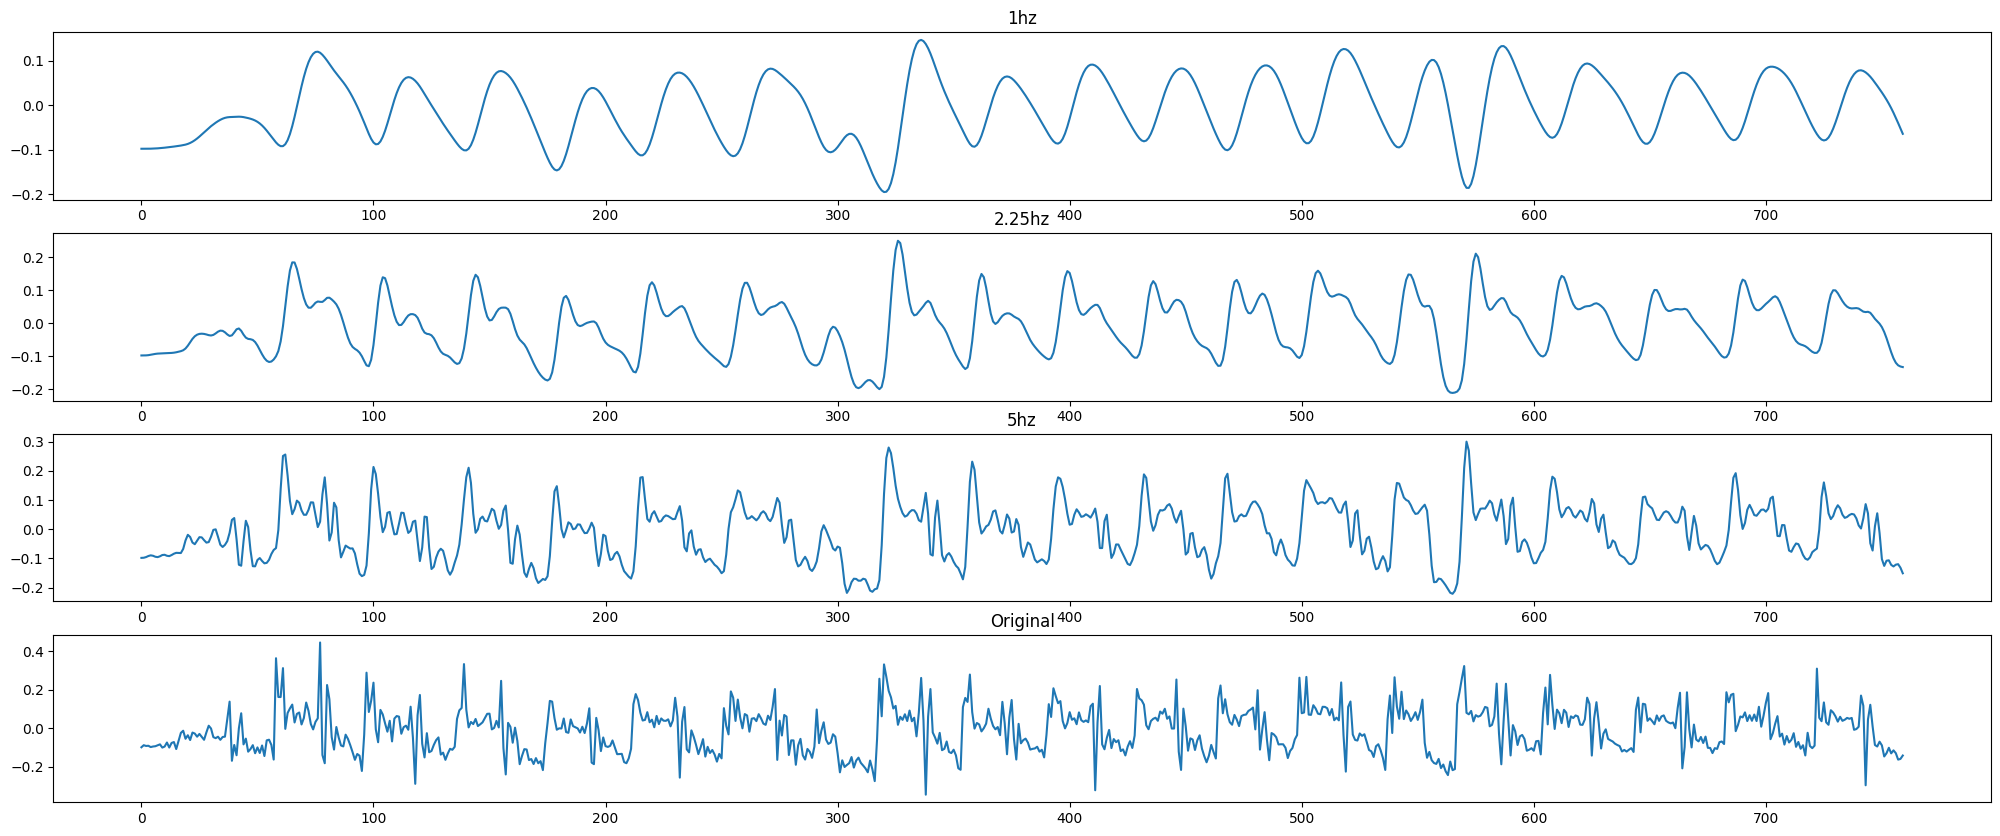

In [8]:
df = import_file("Respeck/S14/S14_respeck_ascending stairs_normal_clean.csv")
# plt.plot(df["accel_x"])
# plt.plot(signal_smoothing(df["accel_x"]),2.25)
# produce 4 subplots for 4 stages of smoothing
fig, axs = plt.subplots(4,1,figsize=(25, 10))
axs[0].plot(signal_smoothing(df["accel_x"],1))
axs[0].set_title("1hz")
axs[1].plot(signal_smoothing(df["accel_x"],2.25))
axs[1].set_title("2.25hz")
axs[2].plot(signal_smoothing(df["accel_x"],5))
axs[2].set_title("5hz")
axs[3].plot(df["accel_x"])
axs[3].set_title("Original")


In [9]:
def get_df(directory='Respeck', freq=2.25, fft_cols=False):
    # Loop through the clean-named subfolders
    all_data = pd.DataFrame()
    data_chunks = []
    
    for student in os.listdir(directory):
        if "placeholder" not in student:
            student_directory = os.path.join(directory, student)
            # itterate through students data
            for file in os.listdir(student_directory):
                file_dir = os.path.join(student_directory, file)
                if os.path.isfile(file_dir) and not "S37" in file:
                    df = import_file(file_dir)
                    if freq != -1:
                        df["accel_x"] = signal_smoothing(df["accel_x"],freq)
                        df["accel_y"] = signal_smoothing(df["accel_y"],freq)
                        df["accel_z"] = signal_smoothing(df["accel_z"],freq)
                    df = base_feature_extraction(df, fft_cols)
                    all_data = pd.concat([all_data, df])
                    data_chunks.append(df)
                    
    return all_data, data_chunks

In [10]:
df, data_chunks = get_df('Respeck')

In [31]:
data_chunks.shape

AttributeError: 'list' object has no attribute 'shape'

In [30]:
data_chunks

[      accel_x   accel_y   accel_z            activity activity_subtype  \
 0   -0.795629  0.099362 -0.597581  lying down on left          singing   
 1   -0.795708  0.099464 -0.597457  lying down on left          singing   
 2   -0.796429  0.092819 -0.597566  lying down on left          singing   
 3   -0.793238  0.102347 -0.600249  lying down on left          singing   
 4   -0.799231  0.096247 -0.593267  lying down on left          singing   
 ..        ...       ...       ...                 ...              ...   
 755 -0.828440  0.079415 -0.554419  lying down on left          singing   
 756 -0.816039  0.077610 -0.572763  lying down on left          singing   
 757 -0.805051  0.070648 -0.588984  lying down on left          singing   
 758 -0.817419  0.078081 -0.570727  lying down on left          singing   
 759 -0.818794  0.069344 -0.569883  lying down on left          singing   
 
      magnitude    jerk_x    jerk_y    jerk_z  jerk_mag  ...  f_accel_x  \
 0     0.994509 -0.0019

In [12]:
df

accel_x   accel_y   accel_z               activity activity_subtype  \
0   -0.795629  0.099362 -0.597581     lying down on left          singing   
1   -0.795629  0.099362 -0.597580     lying down on left          singing   
2   -0.795633  0.099342 -0.597578     lying down on left          singing   
3   -0.795644  0.099234 -0.597581     lying down on left          singing   
4   -0.795655  0.098987 -0.597607     lying down on left          singing   
..        ...       ...       ...                    ...              ...   
755 -0.022967  0.023187 -0.999467  lying down on stomach          singing   
756 -0.022596  0.023408 -0.999471  lying down on stomach          singing   
757 -0.022738  0.023886 -0.999456  lying down on stomach          singing   
758 -0.023335  0.024631 -0.999424  lying down on stomach          singing   
759 -0.024205  0.025479 -0.999382  lying down on stomach          singing   

     magnitude    jerk_x    jerk_y    jerk_z  jerk_mag  pca_accel  pca_jerk  
0     0.994509 -0.000007  0.000009  0.000010  0.000015  -0.026266  0.001011  
1     0.994506 -0.000057 -0.000249  0.000034  0.000257  -0.026266  0.001100  
2     0.994510 -0.000192 -0.001604 -0.000011  0.001615  -0.026265  0.001751  
3     0.994528 -0.000276 -0.004435 -0.000368  0.004459  -0.026277  0.003393  
4     0.994437 -0.000239 -0.007149 -0.000866  0.007205  -0.026328  0.005134  
..         ...       ...       ...       ...       ...        ...       ...  
755   0.992516  0.014496  0.003296 -0.000259  0.014868  -0.005485 -0.014110  
756   0.992168  0.002863  0.008743  0.000140  0.009201  -0.005134 -0.001440  
757   0.991902 -0.009239  0.015285  0.000580  0.017870  -0.005316  0.011975  
758   0.991761 -0.018346  0.019909  0.000923  0.027088  -0.005976  0.021989  
759   0.991805 -0.021756  0.021196  0.001049  0.030393  -0.006916  0.025621  

[1502599 rows x 12 columns]

In [13]:
def summarise_window(df):
    data = []
    for column in df.columns:
        data.append(column_summary(df[column]))
    return np.array(data)

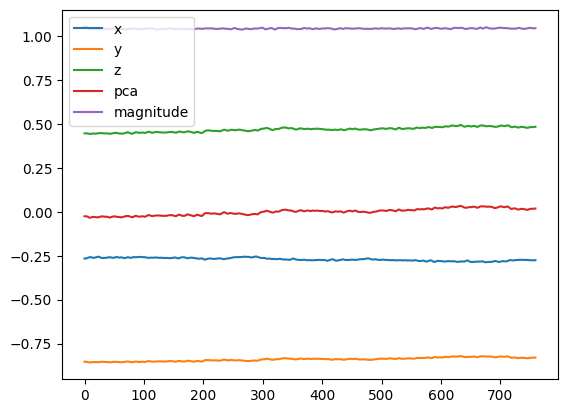

In [14]:
i=1
plt.plot(data_chunks[i]["accel_x"], label = "x")
plt.plot(data_chunks[i]["accel_y"], label ="y")
plt.plot(data_chunks[i]["accel_z"], label = "z")
plt.plot(data_chunks[i]["pca_accel"], label = "pca")
plt.plot(data_chunks[i]["magnitude"], label = "magnitude")
plt.legend()

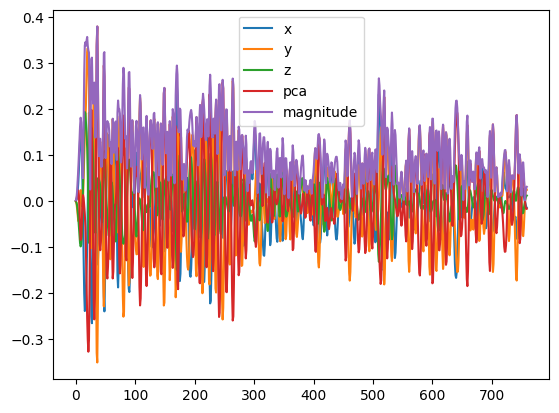

In [15]:
i=100
plt.plot(data_chunks[i]["jerk_x"], label = "x")
plt.plot(data_chunks[i]["jerk_y"], label ="y")
plt.plot(data_chunks[i]["jerk_z"], label = "z")
plt.plot(data_chunks[i]["pca_jerk"], label = "pca")
plt.plot(data_chunks[i]["jerk_mag"], label = "magnitude")
plt.legend()

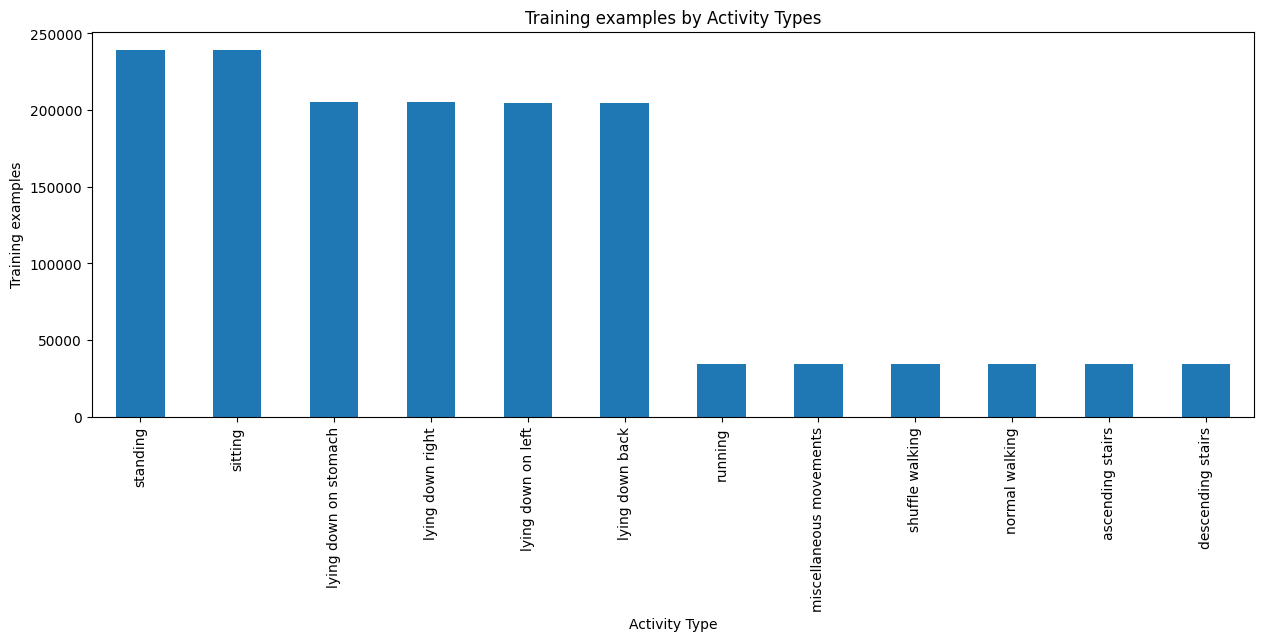

In [16]:
plt.figure(figsize=(15, 5))

plt.xlabel('Activity Type')
plt.ylabel('Training examples')
df['activity'].value_counts().plot(kind='bar',
                                  title='Training examples by Activity Types')
plt.show()

In [17]:
# get physical data only for breathing normally
def get_X_y_phys(data_chunks, window_size = 50, overlap = 25):
    X = []
    y = []
    for data in data_chunks:
        if data.iloc[0]['activity_subtype'] in ["normal"]:
            for i in range(0, len(data) - window_size + 1, overlap):
                # get window
                window = data[i:i + window_size].copy()
                x_data = window.drop(columns=['activity', 'activity_subtype'])
                # create X matrix
                X.append(x_data)
                # create y matrix
                y.append(window.iloc[0]['activity'])
    return np.array(X), np.array(y).reshape(-1,1)
# gets the physical activity for all tasks
def get_X_y_all_phys(data_chunks, window_size = 50, overlap = 25):
    X = []
    y = []
    for data in data_chunks:
        for i in range(0, len(data) - window_size + 1, overlap):
            # get window
            window = data[i:i + window_size].copy()
            x_data = window.drop(columns=['activity', 'activity_subtype'])
            # create X matrix
            X.append(x_data)
            # create y matrix
            y.append(window.iloc[0]['activity'])
            
    return np.array(X), np.array(y).reshape(-1,1)

# this outputs data that has both the physical and subtype in the y for respiratory stationary tasks
def get_X_y_resp(data_chunks, window_size = 50, overlap = 25):
    X = []
    y = []
    for data in data_chunks:
        if data.iloc[0]['activity_subtype'] in ["normal", "coughing", "hyperventilating"] and not data.iloc[0]['activity'] in ["normal walking", "shuffle walking","running", "miscellaneous movements", "ascending stairs", "descending stairs"]:
            for i in range(0, len(data) - window_size + 1, overlap):
                # get window
                window = data[i:i + window_size].copy()
                x_data = window.drop(columns=['activity', 'activity_subtype'])
                # create X matrix
                X.append(x_data)
                # create y matrix
                y.append(window["activity"].iloc[0] +"|" +window["activity_subtype"].iloc[0])
                
    return np.array(X), np.array(y).reshape(-1,1)

# this outputs data that has the subtype in the y for all stationary tasks
def get_X_y_resp_other(data_chunks, window_size = 50, overlap = 25):
    X = []
    y = []
    for data in data_chunks:
        if not data.iloc[0]['activity'] in ["normal walking", "shuffle walking","running", "miscellaneous movements", "ascending stairs", "descending stairs"]:
            for i in range(0, len(data) - window_size + 1, overlap):
                # get window
                window = data[i:i + window_size].copy()
                x_data = window.drop(columns=['activity', 'activity_subtype'])
                # create X matrix
                X.append(x_data)
                # create y matrix
                y.append(window["activity_subtype"].iloc[0])
    return np.array(X), np.array(y).reshape(-1,1)


# this outputs data that has both the physical and subtype in the y for all stationary tasks
def get_X_y_all(data_chunks, window_size = 50, overlap = 25):
    X = []
    y = []
    for data in data_chunks:
        if not data.iloc[0]['activity'] in ["normal walking", "shuffle walking","running", "miscellaneous movements", "ascending stairs", "descending stairs"]:
            for i in range(0, len(data) - window_size + 1, overlap):
                # get window
                window = data[i:i + window_size].copy()
                x_data = window.drop(columns=['activity', 'activity_subtype'])
                # create X matrix
                X.append(x_data)
                # create y matrix
                y.append(window["activity"].iloc[0] +"| " +window["activity_subtype"].iloc[0])
    return np.array(X), np.array(y).reshape(-1,1)

In [18]:
# get data with 2.25hz smoothing and no fft
df, data_chunks = get_df('Respeck')

In [20]:
output_directory = "/Users/apple/Library/Mobile Documents/com~apple~CloudDocs/Year 3/Final-Project/0 Modules/IoT/CW3/dataset"
# Make sure the directory exists, create it if it does not
if not os.path.exists(output_directory):
  os.makedirs(output_directory)

In [28]:
X,y = get_X_y_phys(data_chunks)
X_file_path = os.path.join(output_directory, 'X_respeck_phys')
file = open(X_file_path, 'wb')
pickle.dump(X, file)
file.close()
y_file_path = os.path.join(output_directory, 'y_respeck_phys')
file = open(y_file_path, 'wb')
pickle.dump(y, file)
file.close()

In [25]:
X,y = get_X_y_all_phys(data_chunks)
X_file_path = os.path.join(output_directory, 'X_respeck_phys')
file = open(X_file_path, 'wb')
pickle.dump(X, file)
file.close()
y_file_path = os.path.join(output_directory, 'y_respeck_phys')
file = open(y_file_path, 'wb')
pickle.dump(y, file)
file.close()

In [23]:
# get the data with no smoothing and fft - -1 is the flag for no smoothing, True is the flag for fft
df, data_chunks = get_df('Respeck', -1, True)

In [26]:
X,y = get_X_y_resp(data_chunks)
X_file_path = os.path.join(output_directory, 'X_respeck_resp')
file = open(X_file_path, 'wb')
pickle.dump(X, file)
file.close()
y_file_path = os.path.join(output_directory, 'y_respeck_resp')
file = open(y_file_path, 'wb')
pickle.dump(y, file)
file.close()

In [27]:
X,y = get_X_y_resp_other(data_chunks)
X_file_path = os.path.join(output_directory, 'X_respeck_resp_other')
file = open(X_file_path, 'wb')
pickle.dump(X, file)
file.close()
y_file_path = os.path.join(output_directory, 'y_respeck_resp_other')
file = open(y_file_path, 'wb')
pickle.dump(y, file)
file.close()

In [22]:
# X,y = get_X_y_all(data_chunks)
# print(X.shape, y.shape)
# file = open('X_respeck_all', 'wb')
# pickle.dump(X, file)
# file.close()
# file = open('y_respeck_all', 'wb')
# pickle.dump(y, file)
# file.close()
# print(y[0])

In [ ]:
X,y = get_X_y_all(data_chunks)
X_file_path = os.path.join(output_directory, 'X_respeck_all')
file = open(X_file_path, 'wb')
pickle.dump(X, file)
file.close()
y_file_path = os.path.join(output_directory, 'y_respeck_all')
file = open(y_file_path, 'wb')
pickle.dump(y, file)
file.close()

In [23]:
# for w in [25,50]:#,75,100,125,150]:
#     X,y = get_X_y(data_chunks, w)
#     file = open('X_respeck_' + str(w), 'wb')
#     pickle.dump(X, file)
#     file.close()
#     file = open('y_respeck_' + str(w), 'wb')
#     pickle.dump(y, file)
#     file.close()

In [24]:
# for freq in [1,2.25,5]:
#     df, data_chunks = get_df('Respeck', freq=freq)
#     X,y = get_X_y(data_chunks)
#     file = open('X_respeck_' + str(freq), 'wb')
#     pickle.dump(X, file)
#     file.close()
#     file = open('y_respeck_' + str(freq), 'wb')
#     pickle.dump(y, file)
#     file.close()

In [25]:
# file = open('X_thingy', 'wb')
# pickle.dump(X, file)
# file.close()
# file = open('y_thingy', 'wb')
# pickle.dump(y, file)
# file.close()

In [26]:
def column_summary(data):
    # Calculate Mean, Standard Deviation, Median Absolute Deviation
    mean_value = np.mean(data)
    std_dev = np.std(data)
    mad = np.median(np.abs(data - np.median(data)))

    # Calculate Minimum and Maximum Values
    minimum = np.min(data)
    maximum = np.max(data)

    # Calculate Signal Magnitude Area
    sma = np.sum(np.abs(data))

    # Calculate Energy Measure
    energy = np.sum(data ** 2) / len(data)

    # Calculate Inter-quartile Range
    interquartile_range = iqr(data)

    # Calculate Signal Entropy
    signal_entropy = entropy(data)
    
    # calculate number of peaks
    num_peaks = len(find_peaks(data))
    
    #skewness
    skewness = skew(data)
    
    #kurtosis
    kurto = kurtosis(data)

    # Auto-regression coefficients using Burg order equal to 4
    # burg_order = 4
    # coefficients = lfilter(*butter(burg_order, 0.5, output='ba'), data)
    
    return np.array([mean_value, std_dev, mad, minimum, maximum, sma, energy, num_peaks,
                    interquartile_range, signal_entropy, kurto,skewness])
    